In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [18]:
import numpy as np
from scipy import spatial
from scipy.stats import norm, uniform
from tqdm import tqdm

In [3]:
from utilis.utilis import *
from utilis.mdn_utilis import *
from get_datasets import *

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow_probability import distributions as tfd

# Simple model - MSE

In [5]:
def simple_model():
    input_ = layers.Input(shape=(1))
    x = layers.Dense(100, activation='relu')(input_)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dense(50, activation='relu')(x)
    y = layers.Dense(1)(x)
    model = Model(inputs = input_, outputs = y)
    return model

In [6]:
def train_and_plot(period=2, n=1000, epochs=50, loss="mean_squared_error", num_heads=1, verbose=0):
   
    # DATASET
    print('Generating dataset ...')
    y = np.linspace(-1, 1, n)
    x = 7 * np.sin(period * y) + 0.5 * y + 0.5 * np.random.randn(*y.shape)
    
    # TRAIN MODEL
    adam = tf.keras.optimizers.Adam(learning_rate=0.01)
    if num_heads == 1:
        model = simple_model()
        print('Training Simple model ...')
    else: 
        model = multiple_heads_model(num_heads)
        print('Training Mixture model ...')
        
    model.compile(optimizer=adam, loss=loss)
    model.fit(x,y, epochs=epochs, verbose=verbose)
    
    # PLOT
    print('Making predictions ...')
    y_pred = model.predict(x)
    plt.plot(x,y, label='true')
    plt.plot(x,y_pred, label='pred')
    plt.legend()
    plt.show()

# MDN - Mixture Density Network

In [7]:
def mdn(num_components):
    input_ = layers.Input(shape=(1))
    x = layers.Dense(100, activation='tanh')(input_)
    x = layers.Dense(100, activation='tanh')(x)
    
    gaus_components = layers.Dense(num_components)(x)
    means = layers.Dense(num_components)(x)
    log_variances = layers.Dense(num_components)(x)
    variances = tf.exp(log_variances)
    
    y = layers.Concatenate()([gaus_components, means, variances])
    model = Model(inputs = input_, outputs = y)
    return model

def get_mdn_loss(num_comp):
    def mdn_loss(y_true, y_pred):
        
        gaus_comp = y_pred[:,:num_comp], 
        means = y_pred[:,num_comp:2*num_comp]
        variances = y_pred[:,2*num_comp:]

        # this converts axis=1 of means  and variancesinto a list
        means = tf.split(means, num_or_size_splits=num_comp, axis=1)
        variances = tf.split(variances, num_or_size_splits=num_comp, axis=1)
        
        # construct mixture model
        cat = tfd.Categorical(logits=gaus_comp)
        coll = [tfd.Normal(loc=loc, scale=scale) for loc, scale in zip(means, variances)]
        mixture = tfd.Mixture(cat=cat, components=coll)
        
        # calculate log probability
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
 
        return loss
    
    return mdn_loss

In [81]:
import numpy as np
import matplotlib.pyplot as plt

from utilis.mdn_utilis import sample_from_output

def plot_dataset(x, y, category_assignment, title=None):
    num_categories = category_assignment.max() + 1  # +1 because python indexes from 0
    for i in range(num_categories):
        indexes = np.where(category_assignment == i)[0]
        plt.scatter(x[indexes], y[indexes])
    plt.xlabel('x')
    plt.ylabel('y')
    if title:
        plt.title(title) # + f" , {num_categories} mixture components")
    plt.show()


def plot_y_pred(data, y_pred, title=None):
    x_train, y_train, cluster_train, _ = data['train']
    x_test, y_test, cluster_test, _ = data['test']

    # train
    num_categories = cluster_train.max() + 1  # +1 because python indexes from 0
    for i in range(num_categories):
        indexes = np.where(cluster_train == i)[0]
        plt.scatter(x_train[indexes], y_train[indexes], alpha=0.03)

    # test
    plt.gca().set_prop_cycle(None)
    for i in range(num_categories):
        indexes = np.where(cluster_test == i)[0]
        plt.scatter(x_test[indexes], y_pred[indexes])

    plt.xlabel('x')
    plt.ylabel('y')
    if title:
        plt.title(title)



def get_y_pred(model, x_test):
    y_pred_dist = model.predict(x_test)
    num_comp = int(y_pred_dist.shape[1] / 3)

    y_pred = np.zeros(len(x_test))
    for i in range(len(x_test)):
        y_pred[i] = sample_from_output(y_pred_dist[i], num_comp)

    return y_pred, y_pred_dist

# Test - Localisation-specific custom dataset

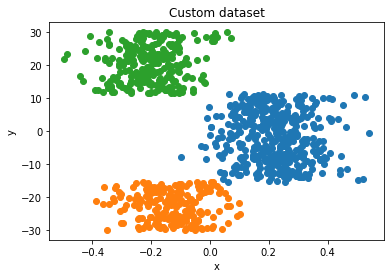

In [114]:
num_components = 3

# get dataset
data = get_dataset__simplified_localisation_problem(N=1000, C=100, num_clusters=num_components, one_to_many=True)
x, y, cluster_assignment, y_shifts = data['train']
plot_dataset(x, y, cluster_assignment, title="Custom dataset")

# get model
model = mdn(num_components)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss=get_mdn_loss(num_components))

In [115]:
epochs = 150

# train model
model.fit(x, y, epochs=epochs)

Epoch 1/150
29/29 [==============================] - 0s 4ms/step - loss: 53.8640
Epoch 2/150
29/29 [==============================] - 0s 4ms/step - loss: 8.8689
Epoch 3/150
29/29 [==============================] - 0s 3ms/step - loss: 5.4292
Epoch 4/150
29/29 [==============================] - 0s 4ms/step - loss: 4.7757
Epoch 5/150
29/29 [==============================] - 0s 3ms/step - loss: 4.5324
Epoch 6/150
29/29 [==============================] - 0s 3ms/step - loss: 4.4086
Epoch 7/150
29/29 [==============================] - 0s 4ms/step - loss: 4.3181
Epoch 8/150
29/29 [==============================] - 0s 4ms/step - loss: 4.2482
Epoch 9/150
29/29 [==============================] - 0s 4ms/step - loss: 4.1962
Epoch 10/150
29/29 [==============================] - 0s 4ms/step - loss: 4.1593
Epoch 11/150
29/29 [==============================] - 0s 4ms/step - loss: 4.1339
Epoch 12/150
29/29 [==============================] - 0s 4ms/step - loss: 4.1173
Epoch 13/150
29/29 [================

In [119]:
def get_mixture_dist(logits, num_components):
    dist = tfd.Categorical(logits=logits)
    n = 1e4
    empirical_prob = tf.cast(
        tf.histogram_fixed_width(
          dist.sample(int(n)),
          [0, num_components-1],
          nbins=num_components),
        dtype=tf.float32) / n
    
    return empirical_prob.numpy()

def plot_probability_density(y_dist, y_range, x_range, N, num_components):
    num_datapoints = y_pred_dist.shape[0]
    num_comp = int(y_pred_dist.shape[1] / 3)
    gaus_components, means, variances = y_dist[:,:num_comp], y_dist[:,num_comp:2*num_comp], y_dist[:,2*num_comp:]

    density_map = np.zeros((N,num_datapoints))      
    for j in range(num_datapoints):
        mixture_distribution = get_mixture_dist(gaus_components[j,:], num_components)
        
        for i in range(num_comp):

            y_points = np.arange(y_range[0], y_range[1], (y_range[1] - y_range[0]) / N)
            probability = norm.pdf(y_points, loc=means[j,i], scale=variances[j,i])
            
            
            density_map[:,j] += mixture_distribution[i] * probability
    
    # normalise
    density_map = density_map / np.sum(density_map)
    
    plt.imshow(density_map)
    plt.ylabel('y axis')
    plt.xlabel('x axis')
    
    # x ticks
    N_x = num_datapoints
    tick_freq = 100
    num_x_ticks = N_x / tick_freq
    x_ticks = np.arange(0,N_x,tick_freq)
    x_labels = np.round(np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / num_x_ticks),1)
    plt.xticks(x_ticks, x_labels)

    # y ticks
    N_y = N
    num_y_ticks = int(N_y / tick_freq)
    y_ticks = np.arange(0,N_y,tick_freq)
    y_labels = np.round(np.arange(y_range[0], y_range[1], (y_range[1] - y_range[0]) / num_y_ticks),1)
    plt.yticks(y_ticks, y_labels)
    
    plt.gca().invert_yaxis()
    plt.show()
    
    return density_map

### Plot sample predictions for X_test

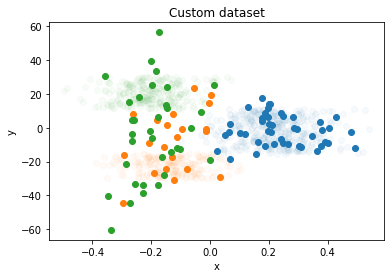

In [117]:
# get predictions
x_test, y_test, _, _ = data['test']
y_pred, y_pred_dist = get_y_pred(model, x_test)

# # plot probability density plot

# plot_probability_density(y_pred_dist, y_range, x_range, N)

# plot pred
plot_y_pred(data, y_pred, title="Custom dataset")

### Plot density map

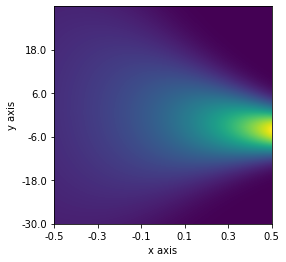

In [120]:
N = 500  # resolution of density plot
y_range = [y.min(), y.max()]
x_range = [x.min(), x.max()]

x_test = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N)
y_pred, y_pred_dist = get_y_pred(model, x_test)

density_map = plot_probability_density(y_pred_dist, y_range, x_range, N, num_components)

# Test - Inverted sinusoid dataset

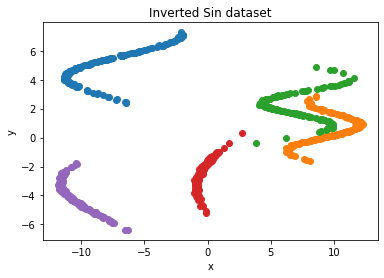

In [101]:
num_components = 15

# get dataset
data = get_dataset__inverted_sinusoid(N=1000, num_sinusoids=5)
x, y, cluster_assignment, _ = data['train']
plot_dataset(x, y, cluster_assignment, title="Inverted Sin dataset")

# get model
model = mdn(num_components)
adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss=get_mdn_loss(num_components))

In [102]:
epochs = 150
# train model
model.fit(x, y, epochs=epochs)

Epoch 1/150
29/29 [==============================] - 0s 6ms/step - loss: 2.9389
Epoch 2/150
29/29 [==============================] - 0s 7ms/step - loss: 2.5274
Epoch 3/150
29/29 [==============================] - 0s 5ms/step - loss: 2.3822
Epoch 4/150
29/29 [==============================] - 0s 6ms/step - loss: 2.2768
Epoch 5/150
29/29 [==============================] - 0s 5ms/step - loss: 2.2248
Epoch 6/150
29/29 [==============================] - 0s 6ms/step - loss: 2.1688
Epoch 7/150
29/29 [==============================] - 0s 6ms/step - loss: 2.1269
Epoch 8/150
29/29 [==============================] - 0s 6ms/step - loss: 2.0982
Epoch 9/150
29/29 [==============================] - 0s 5ms/step - loss: 2.0600
Epoch 10/150
29/29 [==============================] - 0s 6ms/step - loss: 2.0007
Epoch 11/150
29/29 [==============================] - 0s 6ms/step - loss: 1.9508
Epoch 12/150
29/29 [==============================] - 0s 6ms/step - loss: 1.8770
Epoch 13/150
29/29 [=================

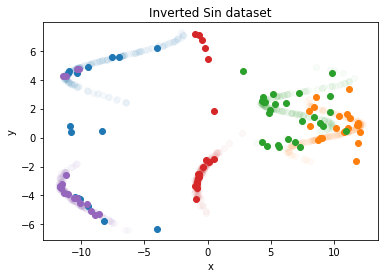

In [103]:
# get predictions
x_test, y_test, _, _ = data['test']
y_pred,y_dist = get_y_pred(model, x_test)

# plot pred
plot_y_pred(data, y_pred, title="Inverted Sin dataset")

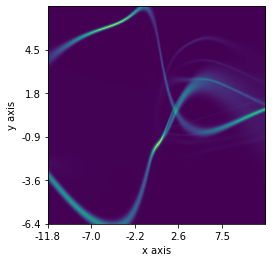

In [104]:
N = 500  # resolution of density plot
y_range = [y.min(), y.max()]
x_range = [x.min(), x.max()]

x_test = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N)
y_pred, y_pred_dist = get_y_pred(model, x_test)

density_map = plot_probability_density(y_pred_dist, y_range, x_range, N, num_components)

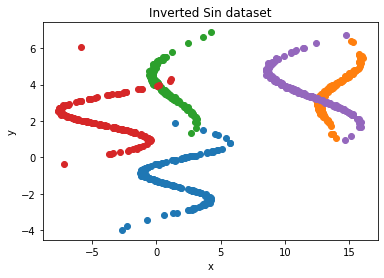

In [88]:
plot_dataset(x, y, cluster_assignment, title="Inverted Sin dataset")


# Test - Mixture of linear functions dataset

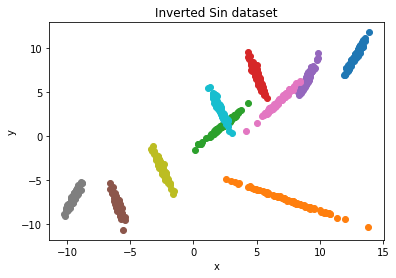

In [122]:
num_components = 15

# get dataset
data = get_dataset__many_linear_functions(N = 1000, num_components=10)
x, y, cluster_assignment,_ = data['train']
plot_dataset(x, y, cluster_assignment, title="Inverted Sin dataset")

# get model
model = mdn(num_components)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss=get_mdn_loss(num_components))

In [123]:
epochs = 150
# train model
model.fit(x, y, epochs=epochs)

Epoch 1/150
29/29 [==============================] - 0s 8ms/step - loss: 3.8487
Epoch 2/150
29/29 [==============================] - 0s 7ms/step - loss: 3.0426
Epoch 3/150
29/29 [==============================] - 0s 6ms/step - loss: 2.4980
Epoch 4/150
29/29 [==============================] - 0s 6ms/step - loss: 2.4259
Epoch 5/150
29/29 [==============================] - 0s 7ms/step - loss: 2.3752
Epoch 6/150
29/29 [==============================] - 0s 6ms/step - loss: 2.3456
Epoch 7/150
29/29 [==============================] - 0s 5ms/step - loss: 2.2339
Epoch 8/150
29/29 [==============================] - 0s 6ms/step - loss: 2.1773
Epoch 9/150
29/29 [==============================] - 0s 7ms/step - loss: 2.1903
Epoch 10/150
29/29 [==============================] - 0s 7ms/step - loss: 2.1981
Epoch 11/150
29/29 [==============================] - 0s 7ms/step - loss: 2.1460
Epoch 12/150
29/29 [==============================] - 0s 5ms/step - loss: 2.1076
Epoch 13/150
29/29 [=================

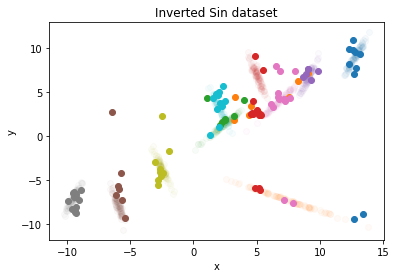

In [126]:
# get predictions
x_test, y_test, _, _ = data['test']
y_pred, y_pred_dist = get_y_pred(model, x_test)

# plot pred
plot_y_pred(data, y_pred, title="Inverted Sin dataset")

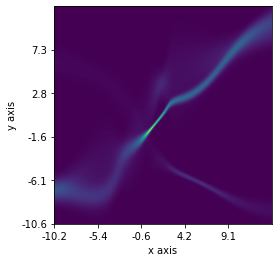

In [127]:
N = 500  # resolution of density plot
y_range = [y.min(), y.max()]
x_range = [x.min(), x.max()]

x_test = np.arange(x_range[0], x_range[1], (x_range[1] - x_range[0]) / N)
y_pred, y_pred_dist = get_y_pred(model, x_test)

density_map = plot_probability_density(y_pred_dist, y_range, x_range, N, num_components)